In [1]:
import pandas as pd 
import numpy as np
import torch 
import copy
import matplotlib
from matplotlib import pyplot as plt

from utils.visuals import visualise_tensors

In [2]:
df = pd.read_pickle('data/in-hospital-mortality/raw_hourly_timeseries.pkl')

In [3]:
train, val, test = torch.load('data/in-hospital-mortality/tensors.pkl')
cols = torch.load('data/in-hospital-mortality/tensor_features.pkl')

In [4]:
# INDEXES 
idx_dict = {
    'CONT': np.arange(14), 
    'CONT_MASK': np.arange(29, 43), 
    'DISC': [np.arange(14, 18), np.arange(18, 24), np.arange(24, 29)],
    'DISC_MASK': np.arange(43, 46)
}
# DISCRETE MAPPING
disc_orders = [
    ['no_response', 'to_pain', 'to_speech', 'spontaneously'], # eyes
    ['no_response', 'abnormal_extension', 'abnormal_flexion', 
              'flex-withdraws', 'localizes_pain', 'obeys_commands'], # motor 
    ['no_response', 'incomprehensible_sounds', 
               'inappropriate_words', 'confused', 'oriented']] # verbal

# SORT DISC ACCORDING TO DISC_ORDERS
import re 
cols = np.array([re.sub('^[^_]*_', '', s) for s in list(cols)] )
new_disc = []
for i,r in enumerate(idx_dict['DISC']): 
    d = dict(zip(list(cols[r]), r))
    temp = [d[j] for j in disc_orders[i]]
    new_disc.append(np.array(temp))
idx_dict['DISC'] = new_disc

In [72]:
data = train[0][:1].squeeze()
prototypes = [train[0][1:2].squeeze(), train[0][2:3].squeeze(), train[0][3:4].squeeze()]
highlights = [[(5,10),(20,25)],[(10,15),(30,40)], [(10,25),(30,45)]]

CPU times: user 3.16 s, sys: 31.2 ms, total: 3.19 s
Wall time: 3.2 s


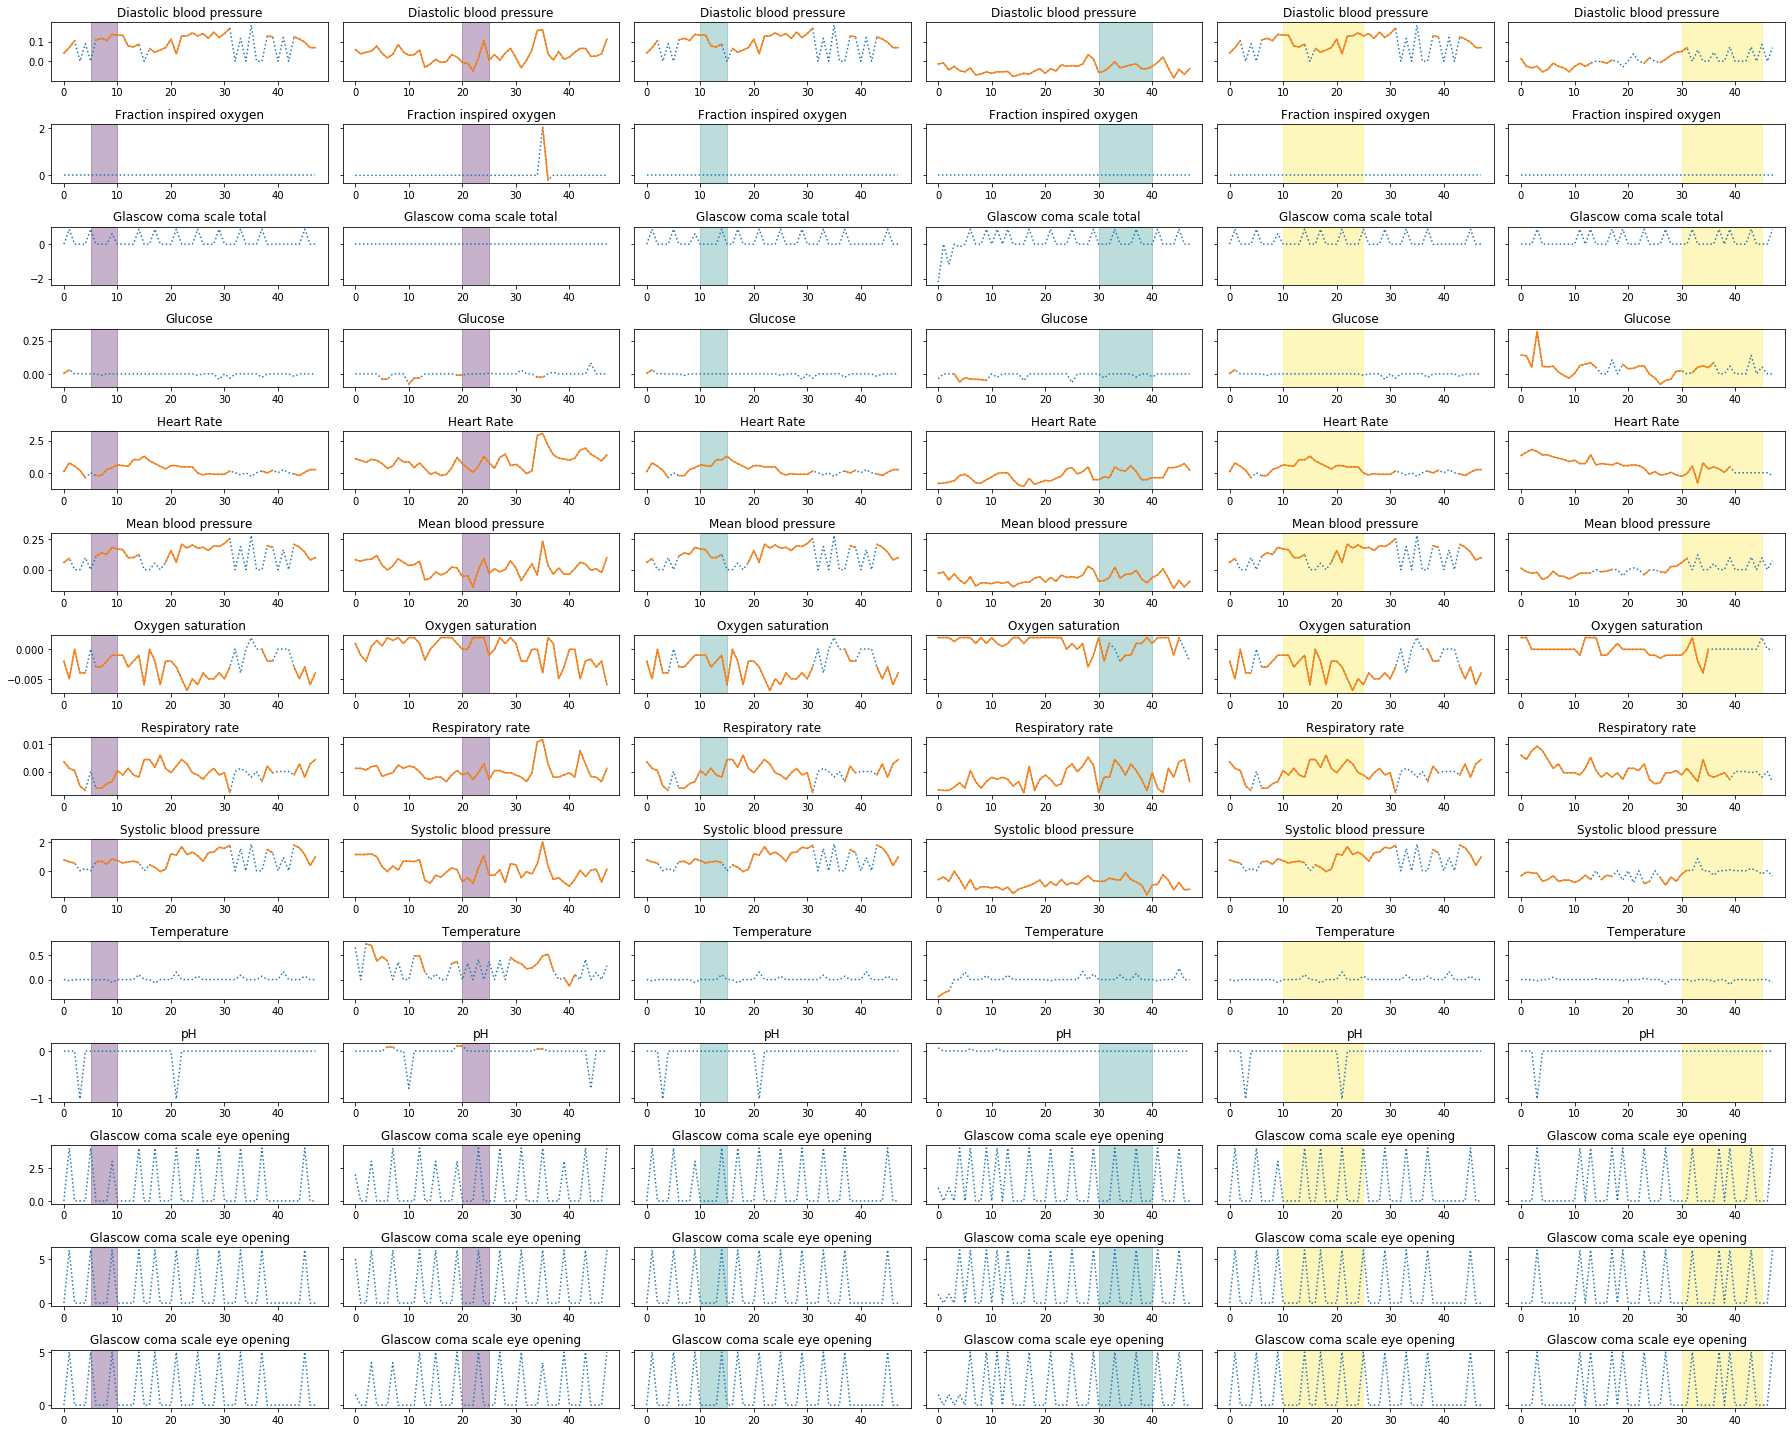

In [73]:
%%time
visualise_tensors(data, prototypes, highlights, cols, idx_dict, exclude=['Capillary refill rate', 'Height', 'Weight'])

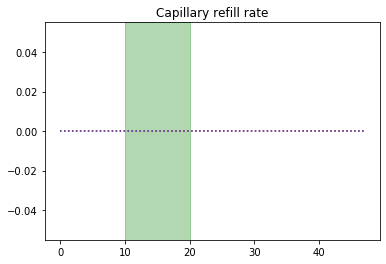

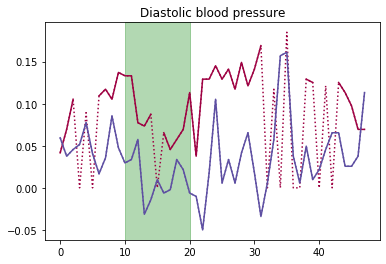

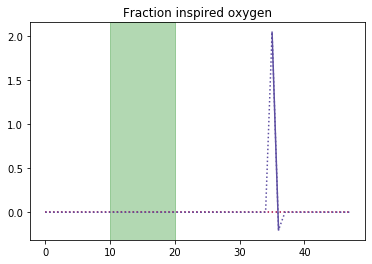

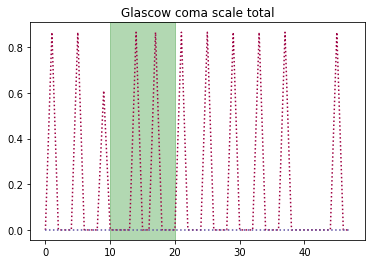

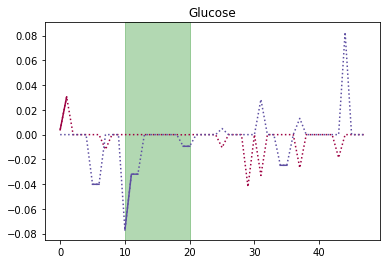

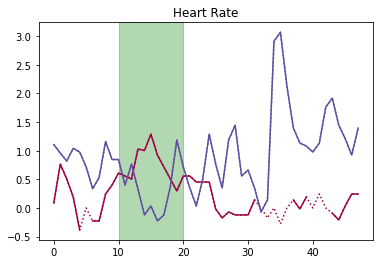

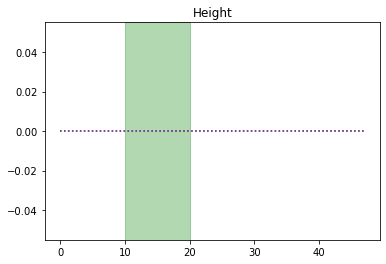

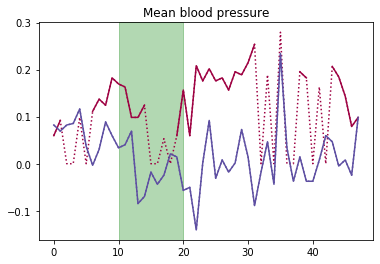

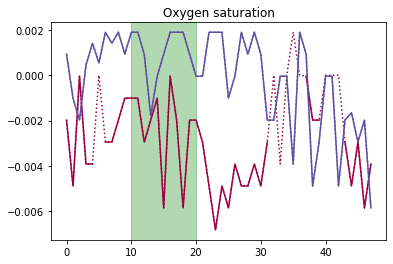

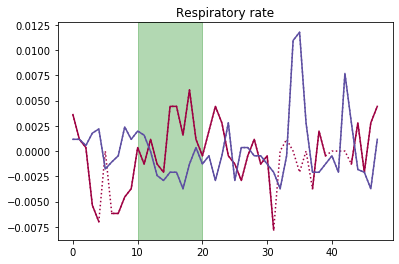

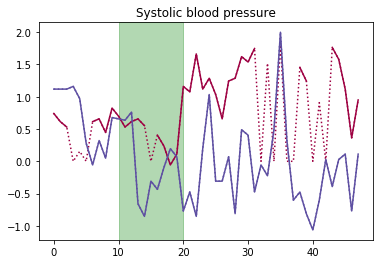

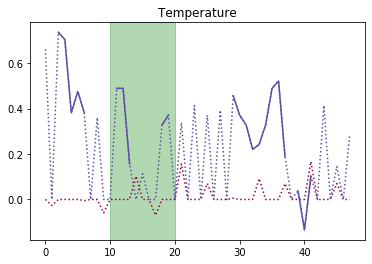

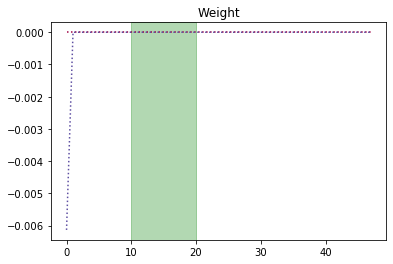

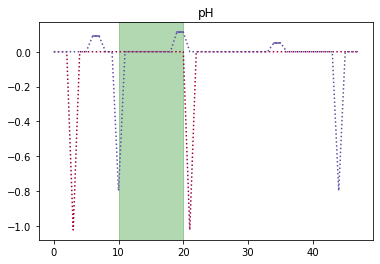

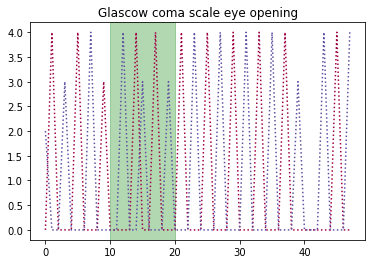

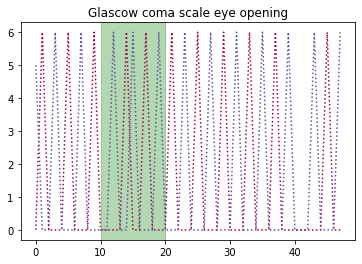

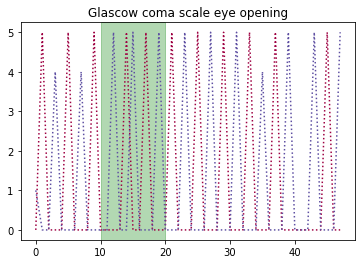

In [7]:
visualise_tensors(train[0][:2], cols, idx_dict, (10, 20))

In [24]:
def disc_transform(a, disc_idx): 
    new = []
    for idx in disc_idx:
        temp = np.array(a)[:,idx] * np.arange(1, len(idx) + 1)
        new.append(temp.sum(axis=1))
    return np.array(new).transpose(1,0)

In [71]:
def visualise_tensors(data, prototypes, highlights, cols, idx_dict, exclude=[], cmap='viridis'):
    """
    data(tensor): sl x dim input tensor 
    prototypes(list of tensors): list of sl x dim prototype tensor 
    highlights(list of list of tuples): pair of ranges for every prototype 
    cols(index): column names 
    idx_dict(dict): dictionary assigning which dimension is of which type (discrete, cont or mask)
    """
    assert len(prototypes) == len(highlights)
    
    data = data.detach().numpy() # patients, sl, dim
    prototypes = [prot.detach().numpy() for prot in prototypes]
    
    cont = idx_dict['CONT']
    cont_mask = idx_dict['CONT_MASK']
    disc_mask = idx_dict['DISC_MASK']
    
    disc_data = disc_transform(data, idx_dict['DISC'])
    disc_prot = [disc_transform(prot, idx_dict['DISC']) for prot in prototypes]
    
    # Plotting 
    axes_rows = cont.shape[0] + disc_mask.shape[0] - len(exclude)  
    fig, axes = plt.subplots(axes_rows, 2 * len(prototypes), sharey='row',figsize=(25, 20), squeeze=False)
    cmap = plt.get_cmap(cmap, len(prototypes))
    colors = [matplotlib.colors.rgb2hex(cmap(i)[:3]) for i in range(len(prototypes))]
    current = 0
    
    ## Plot continuous features
    for i in np.arange(cont.shape[0]):
        if cols[idx_dict['CONT'][i]] not in exclude:  
            for j in np.arange(len(prototypes)): 
                # Data 
                a = copy.deepcopy(data[:,cont[i]])
                plot_one(axes[current, j*2], a, data[:,cont_mask[i]], cols[idx_dict['CONT'][i]], highlights[j][0], colors[j])
                
                # Prototype
                a = copy.deepcopy(prototypes[j][:,cont[i]])
                plot_one(axes[current, j*2+1], a, prototypes[j][:,cont_mask[i]], cols[idx_dict['CONT'][i]], highlights[j][1], colors[j])
                
            current += 1

        
    ## Plot discrete features 
    ### TODO: Maybe a bar plot would be better for this purpose 
    ### TODO: change xlabels into the descriptions
    for i in np.arange(disc_mask.shape[0]):
        colname = cols[idx_dict['DISC_MASK'][0]][:-5]
        if colname not in exclude:  
            for j in np.arange(len(prototypes)): 
                # Data 
                a = copy.deepcopy(disc_data[:,i])
                plot_one(axes[current, j*2], a, data[:,disc_mask[i]], colname, highlights[j][0], colors[j])
                
                # Prototype
                a = copy.deepcopy(disc_prot[j][:,i])
                plot_one(axes[current, j*2+1], a, prototypes[j][:,disc_mask[i]], colname, highlights[j][1], colors[j])
                
            current += 1
            
    plt.tight_layout()

def plot_one(ax, a, mask, title, highlight, color):
    ax.plot(a, linestyle='dotted')
    a[np.where(mask < 1)] = np.nan
    ax.plot(a, linestyle='solid')
    ax.set_title(title)
    ax.axvspan(highlight[0], highlight[1], color=color, alpha=0.3)

In [ ]:
def visualise_tensors(data, prototypes, highlights, cols, idx_dict, exclude=[], cmap='viridis'):
    """
    data(tensor): sl x dim input tensor 
    prototypes(list of tensors): list of sl x dim prototype tensor 
    highlights(list of list of tuples): pair of ranges for every prototype 
    cols(index): column names 
    idx_dict(dict): dictionary assigning which dimension is of which type (discrete, cont or mask)
    """
    assert len(prototypes) == len(highlights)
    
    data = data.detach().numpy() # patients, sl, dim
    cont = idx_dict['CONT']
    cont_mask = idx_dict['CONT_MASK']
    disc_mask = idx_dict['DISC_MASK']
    
    disc_data = disc_transform(data, idx_dict['DISC'])
    disc_prot = [disc_transform(prot.detach().numpy(), idx_dict['DISC']) for prot in prototypes]
    
    # Plotting 
    axes_rows = cont.shape[0] + disc_mask.shape[0] - len(exclude)  
    fig, axes = plt.subplots(axes_rows, 2 * len(prototypes), sharey='row',figsize=(25, 20), squeeze=False)
    cmap = plt.get_cmap(cmap, len(prototypes))
    colors = [matplotlib.colors.rgb2hex(cmap(i)[:3]) for i in range(len(prototypes))]
    current = 0
    
    ## Plot continuous features
    for i in np.arange(cont.shape[0]):
        if cols[idx_dict['CONT'][i]] not in exclude:  
            for j in np.arange(len(prototypes)): 
                # Data 
                a = copy.deepcopy(data[:,cont[i]])
                axes[current, j*2].plot(a, linestyle='dotted')
                a[np.where(data[:,cont_mask[i]] < 1)] = np.nan
                axes[current, j*2].plot(a, linestyle='solid')
                axes[current, j*2].set_title(cols[idx_dict['CONT'][i]])
                axes[current, j*2].axvspan(highlights[j][0][0], highlights[j][0][1], color=colors[j], alpha=0.3)
                
                # Prototype
                a = copy.deepcopy(prototypes[j][:,cont[i]])
                axes[current, j*2+1].plot(a, linestyle='dotted')
                a[np.where(prototypes[j][:,cont_mask[i]] < 1)] = np.nan
                axes[current, j*2+1].plot(a, linestyle='solid')
                axes[current, j*2+1].set_title(cols[idx_dict['CONT'][i]])
                axes[current, j*2+1].axvspan(highlights[j][1][0], highlights[j][1][1], color=colors[j], alpha=0.3)
                
            current += 1

        
    ## Plot discrete features 
    ### TODO: Maybe a bar plot would be better for this purpose 
    ### TODO: change xlabels into the descriptions
    for i in np.arange(disc_mask.shape[0]):
        colname = cols[idx_dict['DISC_MASK'][0]][:-5]
        if colname not in exclude:  
            for j in np.arange(len(prototypes)): 
                # Data 
                a = copy.deepcopy(data[:,cont[i]])
                axes[current, j*2].plot(a, linestyle='dotted')
                a[np.where(data[:,cont_mask[i]] < 1)] = np.nan
                axes[current, j*2].plot(a, linestyle='solid')
                axes[current, j*2].set_title(cols[idx_dict['CONT'][i]])
                axes[current, j*2].axvspan(highlights[j][0][0], highlights[j][0][1], color=colors[j], alpha=0.3)
                
                # Prototype
                a = copy.deepcopy(prototypes[j][:,cont[i]])
                axes[current, j*2+1].plot(a, linestyle='dotted')
                a[np.where(prototypes[j][:,cont_mask[i]] < 1)] = np.nan
                axes[current, j*2+1].plot(a, linestyle='solid')
                axes[current, j*2+1].set_title(cols[idx_dict['CONT'][i]])
                axes[current, j*2+1].axvspan(highlights[j][1][0], highlights[j][1][1], color=colors[j], alpha=0.3)
                
            current += 1
            
    plt.tight_layout()